# Q learning을 구현 - Table Driven
이 파일에서는 gym-FrozenLake 환경에서 Q table 을 학습 및 채워 나가는 코드를 구현
밸만 방정식: 장기적 보상의 최대화는 현재 선택한 액션에서의 즉각적 보상과 최선의 미래에서 주어지는 보상의 합과 같다는 것이 맥락
Q learning에서 Table역할을 할 Network를 구현
네트워크는 16개의 input (space)를 4개의 output (action)으로 매핑할 것
백프로파게이션과 로스함수를 구현
로스함수는 비용의 제곱 형태의 함수

In [2]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\night\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\night\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\night\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\night\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [4]:
env = gym.make('FrozenLake-v0')

In [6]:
tf.reset_default_graph()

# 액션을 선택하는 데 사용되는 네트워크의 피드포워드 부분
inputs1 = tf.placeholder(shape=[1,16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)

# 타깃 Q값과 예측 Q값의 차의 제곱합을 구함으로써 비용함수를 구현
nextQ = tf.placeholder(shape=[1,4], dtype=tf.float32)
loss= tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
updateModel = trainer.minimize(loss)

In [9]:
init = tf.global_variables_initializer()

# 학습 매개변수를 설정한다.
y = .99 # discount factor
e = 0.1 # e - greedy
num_episodes = 2000
# 보상의 총계와 에피소드별 단계 수를 담을 리스트를 생성한다.
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # 환경을 리셋하고 첫 번째 새로운 관찰을 얻는다.
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # Q 네트워크
        while j < 99:
            j += 1
            # Q 네트워크에서 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택
            a,allQ = sess.run([predict,Qout],\
                            feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            # 환경으로부터 새로운 상태와 보상을 얻는다
            s1,r,d,_ = env.step(a[0])
            # 새로운 상태를 네트워크에 피드백해줌으로써 Q'값을 구한다.
            Q1 = sess.run(Qout, feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            # max Q' 값을 구하고 선택된 액션에 대한 타깃 값을 설정한다.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            # 타깃 및 예측 Q 값을 이용하여 네트워크를 학습시킨다.
            _,W1 = sess.run([updateModel, W], feed_dict = {inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll+=r
            s = s1
            if d == True:
                # 모델을 학습해나감에 따라 랜덤 액션의 가능성을 줄여나간다.
                e = 1./((i/50)+10)
                break
        jList.append(j)
        rList.append(rAll)


print("Percent of successful episodes : " + str(sum(rList)/num_episodes))


Percent of successful episodes : 0.1735


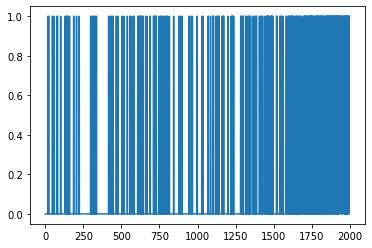

In [10]:
plt.plot(rList)

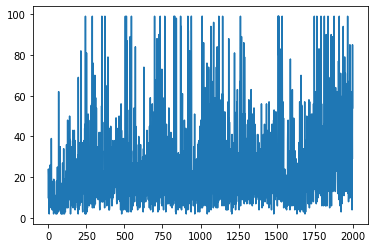

In [11]:
plt.plot(jList)